In [11]:
import numpy as np 
import matplotlib.pyplot as plt
import os
import cv2
import string
from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torch.utils.data import random_split

import torchvision.transforms as transforms

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [13]:
class CustomDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.characters = string.ascii_letters
        self.nchar = len(self.characters)
        self.data = os.listdir(data_dir)

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):

        pic = self.data[idx]
        img_path = os.path.join(self.data_dir, pic)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = Image.fromarray(img)
        img = self.transform(img)

        pic_target = pic[:-5]
        target = np.zeros((len(pic_target), self.nchar), dtype=np.float32)

        for j, char in enumerate(pic_target):
            index = self.characters.find(char)
            target[j,index] = 1

        return img, target

20000 30000
torch.Size([1, 128, 128])
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
  0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
  0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0.]]


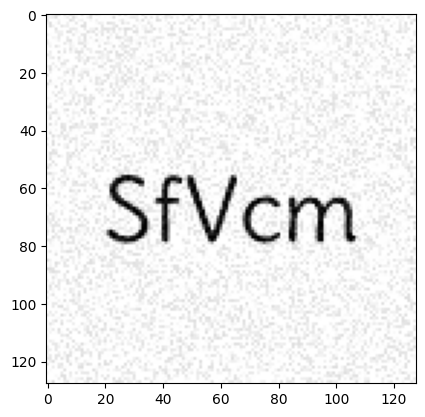

In [14]:
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((128,128)),
    transforms.ToTensor(),  
])

dataset = CustomDataset("data", transform=transform)
train_size = int(0.4 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, pin_memory=True)

print(len(train_dataset), len(test_dataset))

for img,label in train_dataset:
    print(img.shape)
    print(label)
    plt.imshow(img[0],cmap='gray')
    plt.show()
    break

In [15]:
class MyNN(nn.Module):

    def __init__(self, input_features):
        super().__init__()
        
        self.features = nn.Sequential(
            nn.Conv2d(input_features,32,kernel_size=3,padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2,stride=2),

            nn.Conv2d(32,64,kernel_size=3,padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2,stride=2),
        )

        self.shared_dense = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64*32*32,128),
            nn.ReLU(),
            nn.Dropout(p=0.5)
        )

        self.outputs = nn.ModuleList([
            nn.Sequential(
                nn.Linear(128, 64),
                nn.ReLU(),
                nn.Dropout(p=0.5),
                nn.Linear(64, 52)
            )   
            for _ in range(5)
        ])

    def forward(self,x):
        x = self.features(x)
        x = self.shared_dense(x)

        outputs = [output(x) for output in self.outputs]

        return outputs

In [16]:
epochs = 50
learning_rate = 0.001
model = MyNN(1)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=0.0001)

In [17]:
for epoch in range(epochs):

    total_loss = 0
    for batch_features, batch_labels in train_loader:

        batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

        outputs = model(batch_features)

        losses = [
            criterion(output, batch_labels[:, i])
            for i, output in enumerate(outputs)
        ]

        total_loss = sum(losses)

        optimizer.zero_grad()
        total_loss.backward()

        optimizer.step()
        total_loss += total_loss.item()

    avg_loss = total_loss/len(train_loader)
    print(f"Epoch {epoch+1}, Loss: {avg_loss}")

Epoch 1, Loss: 0.06321153789758682
Epoch 2, Loss: 0.06353361159563065
Epoch 3, Loss: 0.06303338706493378
Epoch 4, Loss: 0.06323288381099701
Epoch 5, Loss: 0.06338854134082794
Epoch 6, Loss: 0.06318507343530655
Epoch 7, Loss: 0.06335701793432236
Epoch 8, Loss: 0.06320955604314804
Epoch 9, Loss: 0.0632774829864502
Epoch 10, Loss: 0.06332674622535706
Epoch 11, Loss: 0.06312903016805649
Epoch 12, Loss: 0.06321313232183456
Epoch 13, Loss: 0.0632210448384285
Epoch 14, Loss: 0.06305442005395889
Epoch 15, Loss: 0.06341627985239029
Epoch 16, Loss: 0.0633917972445488
Epoch 17, Loss: 0.06300628185272217
Epoch 18, Loss: 0.06313252449035645
Epoch 19, Loss: 0.06306092441082001
Epoch 20, Loss: 0.06307760626077652
Epoch 21, Loss: 0.06265012919902802
Epoch 22, Loss: 0.06287606060504913
Epoch 23, Loss: 0.06232320889830589
Epoch 24, Loss: 0.06270900368690491
Epoch 25, Loss: 0.06212741509079933
Epoch 26, Loss: 0.06260586529970169
Epoch 27, Loss: 0.061632782220840454
Epoch 28, Loss: 0.06165330484509468
Epo

In [21]:
model.eval()

total_captchas = 0
correct_captchas = 0
total_characters = 0
correct_characters = 0

with torch.no_grad():
    for batch_features, batch_labels in test_loader:
        batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)
        
        batch_labels = torch.argmax(batch_labels, dim=2)
        outputs = model(batch_features)

        outputs = torch.stack(outputs, dim=0)

        predictions = torch.argmax(outputs, dim=2)
        predictions = predictions.permute(1, 0)

        total_captchas += batch_labels.size(0)
        correct_captchas += (predictions == batch_labels).all(dim=1).sum().item()

        total_characters += batch_labels.numel()
        correct_characters += (predictions == batch_labels).sum().item()

captcha_accuracy = 100 * correct_captchas / total_captchas
character_accuracy = 100 * correct_characters / total_characters

print(f"Captcha Accuracy: {captcha_accuracy:.2f}%")
print(f"Character Accuracy: {character_accuracy:.2f}%")


Captcha Accuracy: 48.20%
Character Accuracy: 84.80%


In [19]:
character = [
    'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j',
    'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't',
    'u', 'v', 'w', 'x', 'y', 'z',  'A', 'B', 'C', 'D',
    'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N',
    'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X',
    'Y', 'Z','a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j',
    'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't',
    'u', 'v', 'w', 'x', 'y', 'z',  'A', 'B', 'C', 'D',
    'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N',
    'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X',
    'Y', 'Z'
]

def findWord(k_ind):
    k_ind = k_ind.tolist()
    captcha = ''.join([character[k] for k in k_ind])
    return captcha

In [20]:
with torch.no_grad():
    for batch_features, batch_labels in test_loader:
        batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)
        
        batch_labels = torch.argmax(batch_labels, dim=2)
        outputs = model(batch_features)

        outputs = torch.stack(outputs, dim=0) 

        predictions = torch.argmax(outputs, dim=2)
        predictions = predictions.permute(1, 0)

        for i in range(batch_features.size(0)):
            print(f"Prediction: {findWord(predictions[i])}, Label: {findWord(batch_labels[i])}")

Prediction: FnoFp, Label: FroFp
Prediction: dufxO, Label: dufxO
Prediction: irzGb, Label: irrGb
Prediction: AweDX, Label: AweDX
Prediction: CYmqM, Label: CVmqM
Prediction: mUoHa, Label: nUoHa
Prediction: zrsFt, Label: vasFt
Prediction: WAXdR, Label: WAXdR
Prediction: fJzar, Label: fJzkr
Prediction: KVLCN, Label: KVLCN
Prediction: HnSwZ, Label: HnSwZ
Prediction: XnHkd, Label: XnHkd
Prediction: vEoSV, Label: vEoSV
Prediction: lrlMz, Label: IrIWz
Prediction: kXytt, Label: lXytt
Prediction: foQHU, Label: fcQHU
Prediction: AAmiT, Label: AAniT
Prediction: VFADI, Label: VFADI
Prediction: Pfhau, Label: PIldu
Prediction: FQHme, Label: FQime
Prediction: AlNNS, Label: AlNNS
Prediction: ezcIy, Label: ercly
Prediction: PTtmL, Label: PTtmL
Prediction: cZlJT, Label: cBlIT
Prediction: JpuzB, Label: JpuzB
Prediction: UIsOd, Label: UIsOd
Prediction: WgYaz, Label: WgYaz
Prediction: mmmHH, Label: nnmHt
Prediction: yywqV, Label: yywhV
Prediction: lKPYT, Label: llNRT
Prediction: rXHuh, Label: rXHIh
Predicti